In [1]:
import numpy as np

import numpy as np

def column_select(A, k, epsilon):
    """
    Selects columns from A based on leverage scores using the specified probability formula.
    
    Parameters:
        A (numpy.ndarray): Input matrix.
        k (int): Number of top right singular vectors to use.
        epsilon (float): Controls the scaling factor c in the probability formula.
    
    Returns:
        chosen_columns (numpy.ndarray): Indices of selected columns.
        C (numpy.ndarray): Matrix consisting of selected columns.
    """
    n = A.shape[1]
    U, S, Vt = np.linalg.svd(A, full_matrices=False)  # Compute SVD
    Vt_k = Vt[:k, :]  # Take only the top k right singular vectors

    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)  # Compute leverage scores (pi_j)

    c = k * np.log(k) / (epsilon ** 2)  # Compute the scaling factor

    # Compute selection probabilities: p_j = min(1, c * pi_j)
    selection_probs = np.minimum(1, c * leverage_scores)

    # Randomly include each column based on selection_probs
    chosen_columns = np.where(np.random.rand(A.shape[1]) < selection_probs)[0]
     # Ensure at least c columns are selected|
    return chosen_columns, A[:, chosen_columns]


def row_select(A, num_rows,epsilon):
    """
    Selects `num_rows` rows from A based on leverage scores of A^T.
    """
    row_indices, R = column_select(A.T, num_rows, epsilon)  # Selecting columns of A^T = rows of A
    return row_indices, R.T  # Transpose back to get selected rows

def algorithm_CUR(A, k, epsilon):
    """
    Implements CUR decomposition with dynamic column and row selection.
    
    Parameters:
    A: numpy array
        Input matrix of size (m, n)
    k: int
        Target rank
    epsilon: float
        Error parameter controlling the approximation quality
    
    Returns:
    C, U, R: CUR decomposition matrices
    """
    m, n = A.shape
    
    # Compute c and r dynamically based on k and epsilon
    c = max(k, int(np.ceil((k * np.log(k)) / epsilon**2)))
    r = max(k, int(np.ceil((k * np.log(k)) / epsilon**2)))
    
    # Ensure c and r do not exceed matrix dimensions
    c = min(c, n)
    r = min(r, m)
    
    # Select columns and rows
    col_indices, C = column_select(A, k, epsilon)
    row_indices, R = row_select(A, k, epsilon)
    
    # Compute U = C^+ A R^+
    C_pseudo_inv = np.linalg.pinv(C)
    R_pseudo_inv = np.linalg.pinv(R)
    U = C_pseudo_inv @ A @ R_pseudo_inv
    
    return C, U, R


In [3]:
import random
random.seed(42)
A = np.random.rand(100,100)  # Example matrix
k = 2
epsilon = 0.5 # Small error term

C, U, R = algorithm_CUR(A, k, epsilon)

# Compute CUR approximation error
CUR_approx = C @ U @ R
error_CUR = np.linalg.norm(A - CUR_approx, ord='fro')

# Compute best rank-k SVD approximation error
U_svd, S_svd, Vt_svd = np.linalg.svd(A, full_matrices=False)
A_k = U_svd[:, :k] @ np.diag(S_svd[:k]) @ Vt_svd[:k, :]
error_SVD = np.linalg.norm(A - A_k, ord='fro')

print("CUR Approximation Error:", error_CUR)
print("SVD Rank-k Approximation Error:", error_SVD)
print(f"Is CUR error bounded by (2 + epsilon) * SVD error? {error_CUR <= (2 + epsilon) * error_SVD}")


CUR Approximation Error: 33.06039836385228
SVD Rank-k Approximation Error: 28.16871521054153
Is CUR error bounded by (2 + epsilon) * SVD error? True


In [5]:
num_trials = 1000
failures = 0
errors_CUR = []
errors_SVD = []
bound = (2 + epsilon)
B = np.random.randn(100, 100) * 10
for _ in range(num_trials):
    C, U, R = algorithm_CUR(A, k, epsilon)
    CUR_approx = C @ U @ R
    U_svdb, S_svdb, Vt_svdb = np.linalg.svd(B, full_matrices=False)
    B_k = U_svdb[:, :k] @ np.diag(S_svdb[:k]) @ Vt_svdb[:k, :]
    error_CUR = np.linalg.norm(B - CUR_approx, ord='fro')
    error_SVD = np.linalg.norm(B - B_k, ord='fro')  # Same every time, so you could compute once

    errors_CUR.append(error_CUR)
    errors_SVD.append(error_SVD)
    
    if error_CUR > bound * error_SVD:
        failures += 1

print(f"\nOut of {num_trials} runs, CUR violated the error bound {failures} times.")
print(f"Failure rate: {failures / num_trials * 100:.2f}%")



Out of 1000 runs, CUR violated the error bound 0 times.
Failure rate: 0.00%


In [91]:
A.shape

(100, 100)

In [93]:
print("Shape of C:", C.shape)
print("Shape of R:", R.shape)


Shape of C: (100, 5)
Shape of R: (6, 100)


In [6]:
def compute_leverage_and_cpij(A, k, epsilon):
    """
    Computes leverage scores and sampling probabilities (cpij) for CUR.

    Parameters:
        A (numpy.ndarray): Input matrix of shape (m, n).
        k (int): Number of top right singular vectors to consider.
        epsilon (float): Accuracy parameter for controlling sampling count.

    Returns:
        leverage_scores (numpy.ndarray): Normalized leverage scores (π_j), shape (n,)
        cpij (numpy.ndarray): Sampling probabilities (p_j = min(1, c * π_j)), shape (n,)
    """
    # Step 1: Compute SVD
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    
    # Step 2: Select top-k right singular vectors
    Vt_k = Vt[:k, :]  # Shape (k, n)

    # Step 3: Compute normalized leverage scores
    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)  # Shape (n,)

    # Step 4: Compute c and scaled sampling probabilities
    c = (k * np.log(k)) / (epsilon ** 2)
    cpij = np.minimum(1, c * leverage_scores)  # Sampling probabilities

    return leverage_scores, cpij


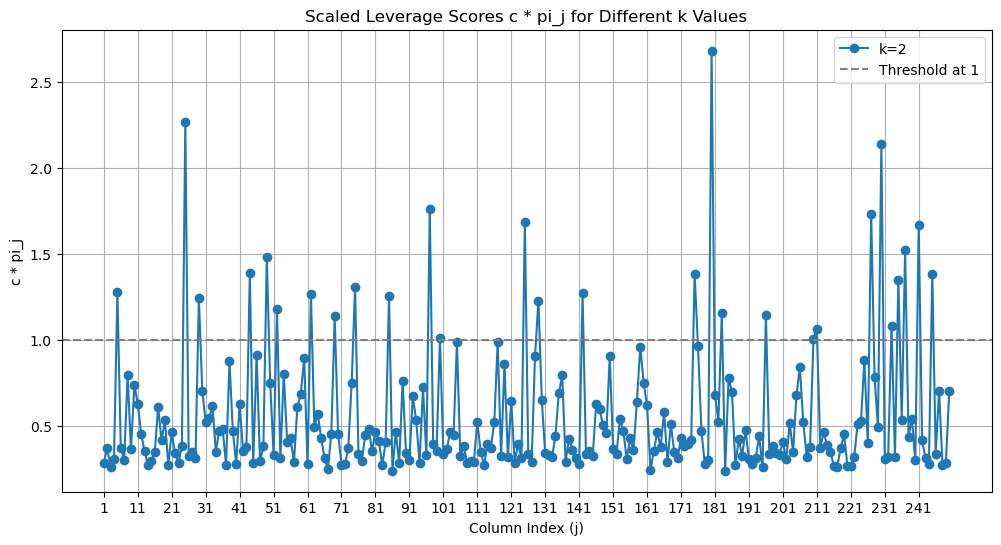

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def compute_leverage_scores(A, k):
    """
    Computes leverage scores (pi_j) for matrix A using the top-k right singular vectors.
    """
    U, S, Vt = np.linalg.svd(A, full_matrices=False)  # Compute SVD
    Vt_k = Vt[:k, :]  # Take the top k right singular vectors
    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)  # Compute leverage scores (pi_j)
    return leverage_scores

# Generate a random matrix A (m x n)
m, n = 250, 250  # Example matrix size
np.random.seed(42)
A = np.random.rand(m, n)

epsilon = 0.1  # Fixed epsilon
k_values = [2]  # Different k values to analyze
column_indices = np.arange(1, n + 1)  # Column indices starting from 1

plt.figure(figsize=(12, 6))

for k in k_values:
    leverage_scores = compute_leverage_scores(A, k)
    c = (k * np.log(k)) / (epsilon ** 2)  # Compute c
    c_pi_j = c * leverage_scores  # Compute c * pi_j

    plt.plot(column_indices, c_pi_j, marker='o', linestyle='-', label=f'k={k}')

plt.axhline(y=1, color='gray', linestyle='--', label='Threshold at 1')
plt.xlabel("Column Index (j)")
plt.ylabel("c * pi_j")
plt.title("Scaled Leverage Scores c * pi_j for Different k Values")

# Set x-axis ticks to show every 10th index (adjust as needed)
plt.xticks(np.arange(1, n + 1, 10))  

plt.legend()
plt.grid(True)
plt.show()


In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_column_norms_vs_scaled_leverage_scores(A, k, epsilon):
    """
    Plots column norms (x-axis) vs scaled leverage scores (c * pi_j) (y-axis).

    Parameters:
        A (numpy.ndarray): The input matrix.
        k (int): Number of top right singular vectors to use.
        epsilon (float): Scaling factor for selection probabilities.
    """
    # SVD to compute leverage scores (pi_j)
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    Vt_k = Vt[:k, :]  # Take top k right singular vectors

    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)  # pi_j
    c = k * np.log(k) / (epsilon ** 2)  # Scaling factor c

    # Scaled leverage scores c * pi_j
    scaled_leverage_scores = c * leverage_scores

    # Column norms (normalized)
    col_norms = np.sum(A**2, axis=0)
    normed_col_norms = col_norms / np.sum(col_norms)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(normed_col_norms, scaled_leverage_scores, color='teal', label='Scaled Leverage Scores (c * pi_j)')
    plt.xlabel('Normalized Column Norms')
    plt.ylabel('Scaled Leverage Scores (c * pi_j)')
    plt.title(f'Column Norms vs Scaled Leverage Scores (k={k}, epsilon={epsilon})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


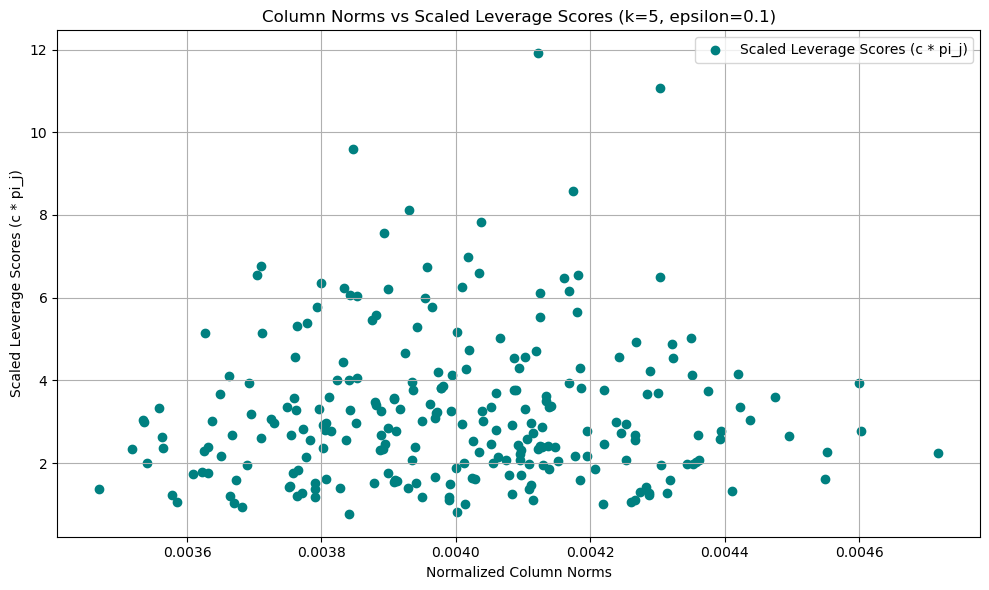

In [17]:
# A = your matrix
k = 5  # Choose number of top right singular vectors
epsilon = 0.1  # Scaling factor

plot_column_norms_vs_scaled_leverage_scores(A, k, epsilon)


In [19]:
def column_select(A, k, epsilon):
    """
    Selects columns from A based on leverage scores using the specified probability formula.
    
    Parameters:
        A (numpy.ndarray): Input matrix.
        k (int): Number of top right singular vectors to use.
        epsilon (float): Controls the scaling factor c in the probability formula.
    
    Returns:
        chosen_columns (numpy.ndarray): Indices of selected columns.
        C (numpy.ndarray): Matrix consisting of selected columns.
    """
    n = A.shape[1]
    U, S, Vt = np.linalg.svd(A, full_matrices=False)  # Compute SVD
    Vt_k = Vt[:k, :]  # Take only the top k right singular vectors

    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)  # Compute leverage scores (pi_j)

    c = k * np.log(k) / (epsilon ** 2)  # Compute the scaling factor

    # Compute selection probabilities: p_j = min(1, c * pi_j)
    selection_probs = np.minimum(1, c * leverage_scores)

    # Randomly include each column based on selection_probs
    chosen_columns = np.where(np.random.rand(A.shape[1]) < selection_probs)[0]
    
    # Ensure at least c columns are selected
    return chosen_columns, A[:, chosen_columns], selection_probs


In [21]:
def row_select(A, num_rows, epsilon):
    """
    Selects `num_rows` rows from A based on leverage scores of A^T.
    """
    row_indices, R, _ = column_select(A.T, num_rows, epsilon)  # Selecting columns of A^T = rows of A
    return row_indices, R.T


In [76]:
def algorithm_CUR(A, k, epsilon):
    """
    Implements CUR decomposition with dynamic column and row selection.
    
    Parameters:
    A: numpy array
        Input matrix of size (m, n)
    k: int
        Target rank
    epsilon: float
        Error parameter controlling the approximation quality
    
    Returns:
    C, U, R: CUR decomposition matrices
    selected_columns: Indices of selected columns
    selected_rows: Indices of selected rows
    """
    m, n = A.shape
    
    # Compute c and r dynamically based on k and epsilon
    c = max(k, int(np.ceil((k * np.log(k)) / epsilon**2)))
    #print(f"c (scaling factor) = {c:.2f}")
    r = max(k, int(np.ceil((k * np.log(k)) / epsilon**2)))
    
    # Ensure c and r do not exceed matrix dimensions
    c = min(c, n)
    r = min(r, m)
    
    # Select columns and rows
    col_indices, C, _ = column_select(A, k, epsilon)
    row_indices, R = row_select(A, k, epsilon)
    
    # Compute U = C^+ A R^+
    C_pseudo_inv = np.linalg.pinv(C)
    R_pseudo_inv = np.linalg.pinv(R)
    U = C_pseudo_inv @ A @ R_pseudo_inv
    
    return C, U, R, col_indices, row_indices


In [25]:
np.random.seed(42)
# Example usage:
A = np.random.rand(250, 250)  # Example matrix
k = 2
epsilon = 0.5

C, U, R, selected_columns, selected_rows = algorithm_CUR(A, k, epsilon)

print("Selected Columns Indices:", selected_columns)
print("Selected Rows Indices:", selected_rows)


c (scaling factor) = 6.00
Selected Columns Indices: [ 49  78  91 224]
Selected Rows Indices: [ 17  22  86  98 134 183 190 225 229]


In [27]:
print("Shape of C:", C.shape)
print("Shape of R:", R.shape)

Shape of C: (250, 4)
Shape of R: (9, 250)


In [29]:
import matplotlib.pyplot as plt

def plot_column_selection_probs(cpij, selected_indices):
    """
    Plots selection probabilities with highlighted and labeled selected columns.
    
    Parameters:
        cpij (numpy.ndarray): Array of selection probabilities (min(1, c * pi_j)).
        selected_indices (numpy.ndarray): Indices of selected columns.
    """
    n = len(cpij)
    x = np.arange(n)

    plt.figure(figsize=(12, 6))

    # Plot all columns in gray
    plt.scatter(x, cpij, color='lightgray', label='Not Selected', s=30)

    # Highlight selected columns in red
    plt.scatter(selected_indices, cpij[selected_indices], color='#003f5c', label='Selected', s=80)

    # Annotate selected columns
    for idx in selected_indices:
        plt.text(idx, cpij[idx] + 0.01, str(idx), color='black', fontsize=9, ha='center', rotation=45)

    plt.xlabel("Column Index")
    plt.ylabel("Selection Probability (cpij)")
    plt.title("Column Selection Probabilities with Selected Columns Highlighted & Labeled")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


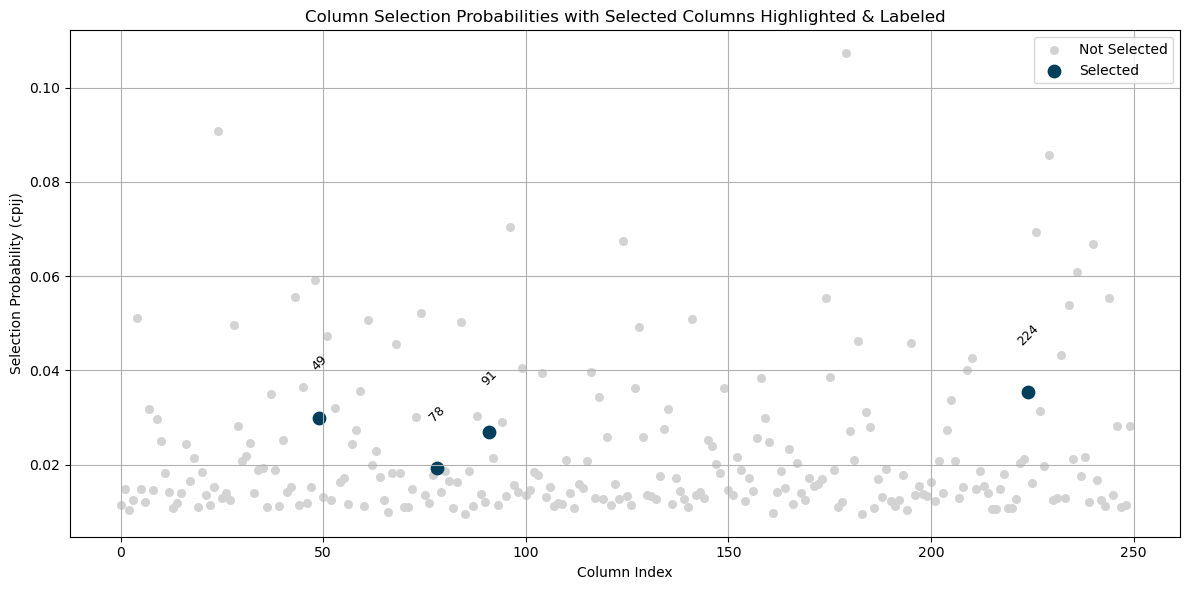

In [31]:
np.random.seed(42)
# Example usage:
A = np.random.rand(250, 250)  # Example matrix
k = 2
epsilon = 0.5
col_indices, C, cpij = column_select(A, k, epsilon)
plot_column_selection_probs(cpij, col_indices)


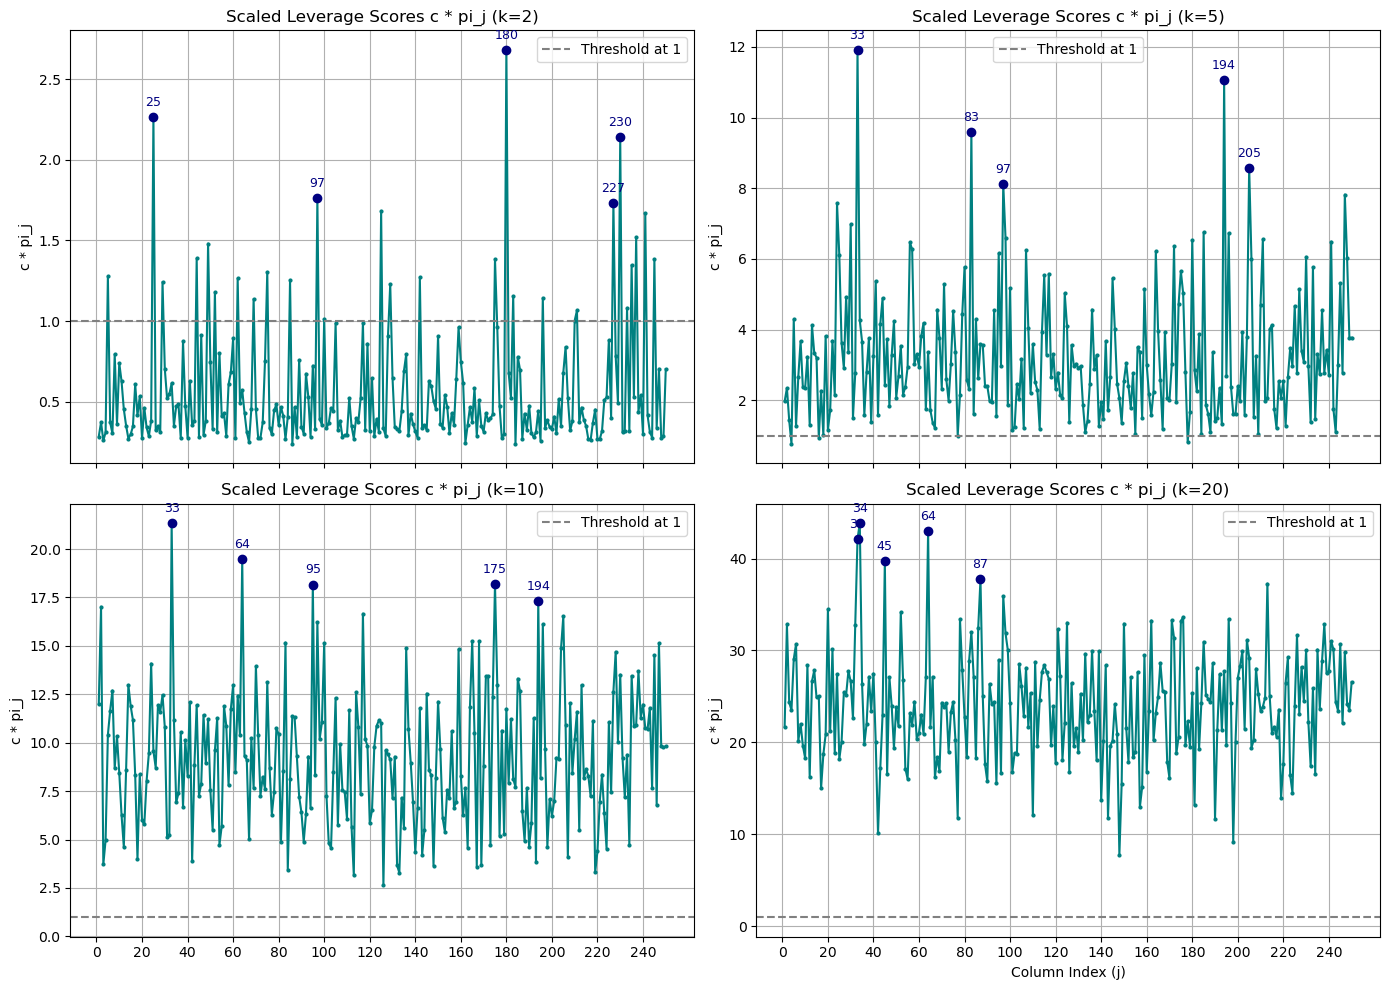

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def compute_leverage_scores(A, k):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    Vt_k = Vt[:k, :]
    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)
    return leverage_scores

# Generate a random matrix
m, n = 250, 250
np.random.seed(42)
A = np.random.rand(m, n)

epsilon = 0.1
k_values = [2, 5, 10, 20]  # Example k values

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, k in enumerate(k_values):
    ax = axes[i] if len(k_values) > 1 else axes
    leverage_scores = compute_leverage_scores(A, k)
    c = (k * np.log(k)) / (epsilon ** 2)
    c_pi_j = c * leverage_scores
    column_indices = np.arange(1, n + 1)

    ax.plot(column_indices, c_pi_j, color='#008080', marker='o', linestyle='-', markersize=2)
    ax.axhline(y=1, color='gray', linestyle='--', label='Threshold at 1')
    ax.set_title(f'Scaled Leverage Scores c * pi_j (k={k})')
    ax.set_ylabel("c * pi_j")
    ax.grid(True)
    ax.legend()

    # Add x-ticks every 10 columns
    ax.set_xticks(np.arange(0, n + 1, 20))

    # Highlight and annotate top 5 c*pi_j values
    top_5_indices = np.argsort(c_pi_j)[-5:]  # Get indices of top 5
    for idx in top_5_indices:
        x = column_indices[idx]
        y = c_pi_j[idx]
        ax.plot(x, y, 'o', color='navy')
        ax.annotate(f'{x}', (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9, color='navy')

# Set x-axis labels only for the bottom-most subplot
axes[-1].set_xlabel("Column Index (j)")

# Adjust the layout to ensure there's space for all labels and titles
plt.tight_layout()

plt.show()


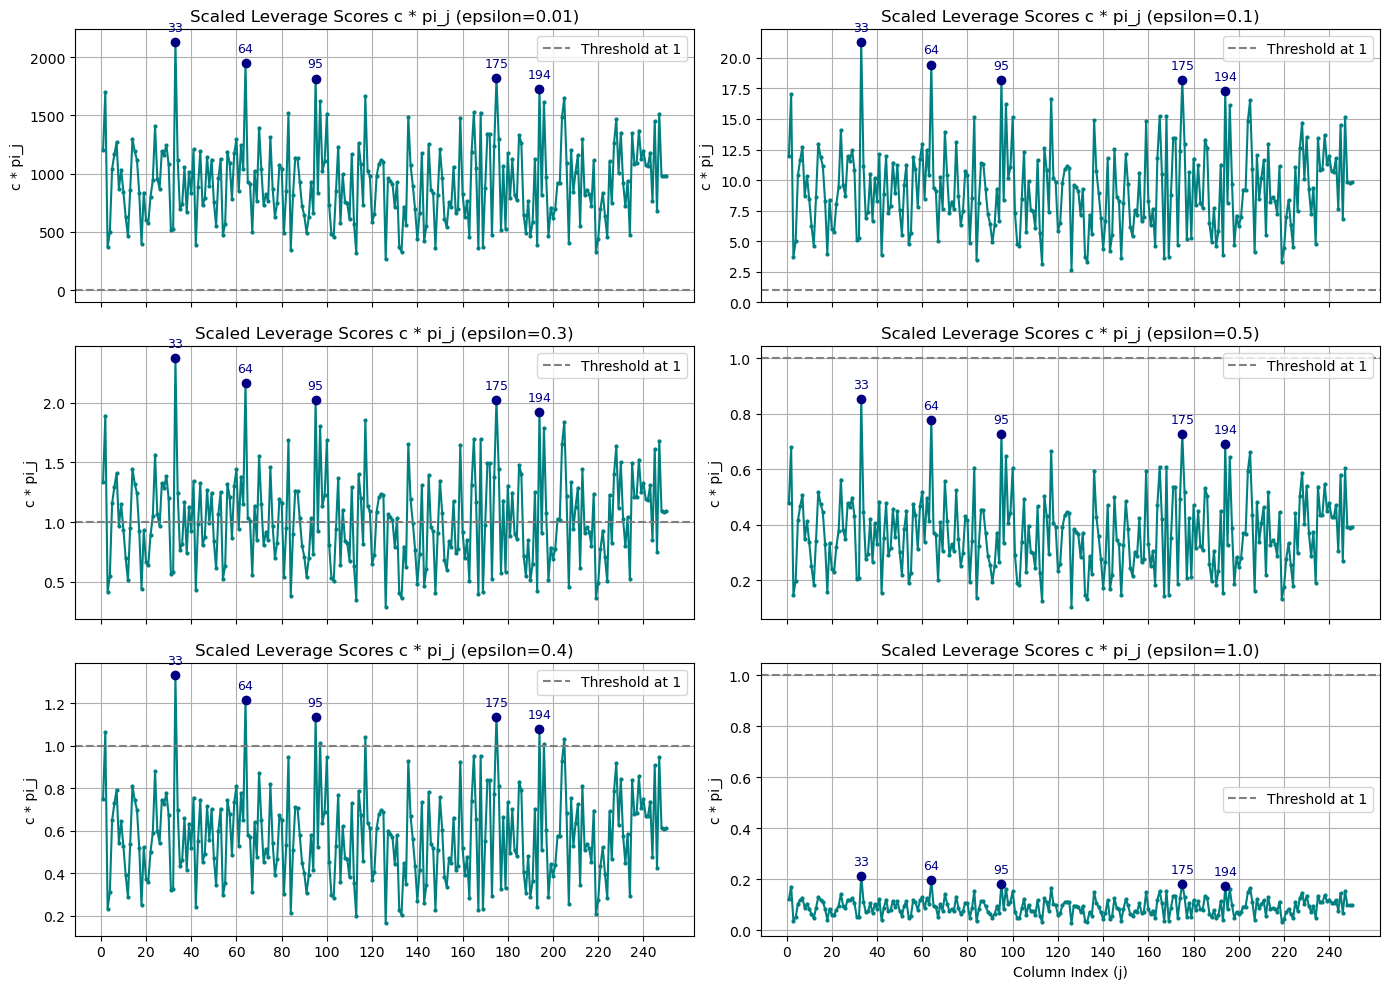

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def compute_leverage_scores(A, k):
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    Vt_k = Vt[:k, :]
    leverage_scores = (1 / k) * np.sum(Vt_k**2, axis=0)
    return leverage_scores

# Generate a random matrix
m, n = 250, 250
np.random.seed(42)
A = np.random.rand(m, n)

k = 10  # Set a fixed k value for comparison
epsilon_values = [0.01, 0.1, 0.3, 0.5,0.4,1.0]  # Example epsilon values

fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()
for i, epsilon in enumerate(epsilon_values):
    ax = axes[i] if len(epsilon_values) > 1 else axes
    leverage_scores = compute_leverage_scores(A, k)
    c = (k * np.log(k)) / (epsilon ** 2)
    c_pi_j = c * leverage_scores
    column_indices = np.arange(1, n + 1)

    ax.plot(column_indices, c_pi_j, color='#008080', marker='o', linestyle='-', markersize=2)
    ax.axhline(y=1, color='gray', linestyle='--', label='Threshold at 1')
    ax.set_title(f'Scaled Leverage Scores c * pi_j (epsilon={epsilon})')
    ax.set_ylabel("c * pi_j")
    ax.grid(True)
    ax.legend()

    # Add x-ticks every 10 columns
    ax.set_xticks(np.arange(0, n + 1, 20))

    # Highlight and annotate top 5 c*pi_j values
    top_5_indices = np.argsort(c_pi_j)[-5:]  # Get indices of top 5
    for idx in top_5_indices:
        x = column_indices[idx]
        y = c_pi_j[idx]
        ax.plot(x, y, 'o', color='navy')
        ax.annotate(f'{x}', (x, y), textcoords="offset points", xytext=(0, 8), ha='center', fontsize=9, color='navy')

axes[-1].set_xlabel("Column Index (j)")
plt.tight_layout()
plt.show()


c (scaling factor) = 6.00


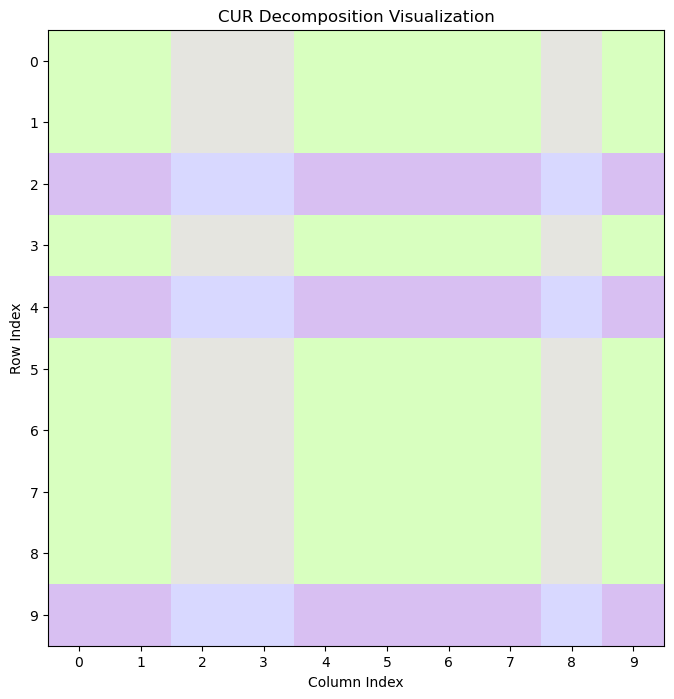

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Sample matrix A (you can replace it with your actual matrix)
A = np.random.rand(10, 10)
k=2
epsilon=0.5
C, U, R, col_indices, row_indices = algorithm_CUR(A, k, epsilon)


# Colors in RGB (0 to 1 scale)
light_gray = np.array([0.9, 0.9, 0.88])  # Light gray
light_purple = np.array([0.85, 0.85, 0.95])  # Soft pastel lavender
off_white = np.array([0.85, 0.85, 1.0])  # Soft pastel blue
peach = np.array([0.85, 1.0, 0.75])  # Soft pastel green
overlap_color = np.array([0.85, 0.75, 0.95])  # Soft lavender for overlap

# Initialize with light gray (deselected)
color_matrix = np.tile(light_gray, A.shape + (1,))

# Apply row color (light purple)
for i in row_indices:
    color_matrix[i, :, :] = off_white

# Apply column color (peach)
for j in col_indices:
    color_matrix[:, j, :] = peach

# Apply overlap color (override where both row and column are selected)
for i in row_indices:
    for j in col_indices:
        color_matrix[i, j, :] = overlap_color

# Plot
# Plot
plt.figure(figsize=(8, 8))
plt.imshow(color_matrix, aspect='equal')
plt.title("CUR Decomposition Visualization")

# Add column and row indices as ticks
plt.xticks(ticks=np.arange(A.shape[1]), labels=np.arange(A.shape[1]), fontsize=10)
plt.yticks(ticks=np.arange(A.shape[0]), labels=np.arange(A.shape[0]), fontsize=10)

plt.xlabel("Column Index")
plt.ylabel("Row Index")

plt.grid(False)
plt.show()


In [125]:
!pip install imageio[ffmpeg]


In [71]:
import os
os.getcwd()


'C:\\Users\\Riya Huddar\\Downloads'

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import os

# Ensure a folder for videos exists
os.makedirs("animations1", exist_ok=True)

# Parameters
A = np.random.rand(10, 10)  # Example matrix A
k = 2
epsilon = 0.5

# Colors in RGB (0 to 1 scale)
light_gray = np.array([0.9, 0.9, 0.88])  # Light gray
light_purple = np.array([0.85, 0.85, 0.95])  # Soft pastel lavender
off_white = np.array([0.85, 0.85, 1.0])  # Soft pastel blue
peach = np.array([0.85, 1.0, 0.75])  # Soft pastel green
overlap_color = np.array([0.85, 0.75, 0.95])  # Soft lavender for overlap
# Animation function
def generate_animation(run_id):
    # Get CUR decomposition (can change the matrix A or parameters in each frame)
    C, U, R, col_indices, row_indices = algorithm_CUR(A, k, epsilon)

    # Initialize with light gray (deselected)
    color_matrix = np.tile(light_gray, A.shape + (1,))

    # Apply row color (light purple)
    for i in row_indices:
        color_matrix[i, :, :] = off_white

    # Apply column color (peach)
    for j in col_indices:
        color_matrix[:, j, :] = peach

    # Apply overlap color (override where both row and column are selected)
    for i in row_indices:
        for j in col_indices:
            color_matrix[i, j, :] = overlap_color

    # Plot each frame in the animation
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(color_matrix, aspect='equal')
    ax.set_title(f"CUR Decomposition Visualization (Run {run_id+1})")
    ax.set_xticks(np.arange(A.shape[1]))
    ax.set_yticks(np.arange(A.shape[0]))
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.grid(False)

    # Save the animation frame as a gif
    filename = f"animations1/run_{run_id+1}.gif"
    ani = FuncAnimation(fig, lambda x: x, frames=1, blit=False)  # Single frame animation
    ani.save(filename, writer='pillow', fps=30)
    plt.close(fig)

# 🌀 Run the animation generation 33 times
for i in range(33):
    print(f"Rendering animation {i+1}/33...")
    generate_animation(i)

print("🎉 All animations rendered and saved in the 'animations/' folder!")


Rendering animation 1/33...
c (scaling factor) = 6.00
Rendering animation 2/33...
c (scaling factor) = 6.00
Rendering animation 3/33...
c (scaling factor) = 6.00
Rendering animation 4/33...
c (scaling factor) = 6.00
Rendering animation 5/33...
c (scaling factor) = 6.00
Rendering animation 6/33...
c (scaling factor) = 6.00
Rendering animation 7/33...
c (scaling factor) = 6.00
Rendering animation 8/33...
c (scaling factor) = 6.00
Rendering animation 9/33...
c (scaling factor) = 6.00
Rendering animation 10/33...
c (scaling factor) = 6.00
Rendering animation 11/33...
c (scaling factor) = 6.00
Rendering animation 12/33...
c (scaling factor) = 6.00
Rendering animation 13/33...
c (scaling factor) = 6.00
Rendering animation 14/33...
c (scaling factor) = 6.00
Rendering animation 15/33...
c (scaling factor) = 6.00
Rendering animation 16/33...
c (scaling factor) = 6.00
Rendering animation 17/33...
c (scaling factor) = 6.00
Rendering animation 18/33...
c (scaling factor) = 6.00
Rendering animation

In [121]:
from PIL import Image
import os

# Path to your GIF frames
frames_dir = r'C:\Users\Riya Huddar\Downloads\animations1'  # Adjust the folder path if necessary

# Create a list to store the frames
frames = []

# Loop through each GIF frame and append it to the frames list
for i in range(33):  # Assuming there are 33 frames
    frame_path = os.path.join(frames_dir, f'run_{i + 1}.gif')  # Adjust the naming if necessary
    try:
        frame = Image.open(frame_path)
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: {frame_path} not found.")

# Create the GIF from the frames (adjust duration between frames if needed)
output_gif_path = os.path.join(frames_dir, 'combined_animation.gif')  # Output GIF path
frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], loop=0, duration=200)

print(f"GIF saved successfully to {output_gif_path}")


GIF saved successfully to C:\Users\Riya Huddar\Downloads\animations1\combined_animation.gif


c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c (scaling factor) = 14.00
c

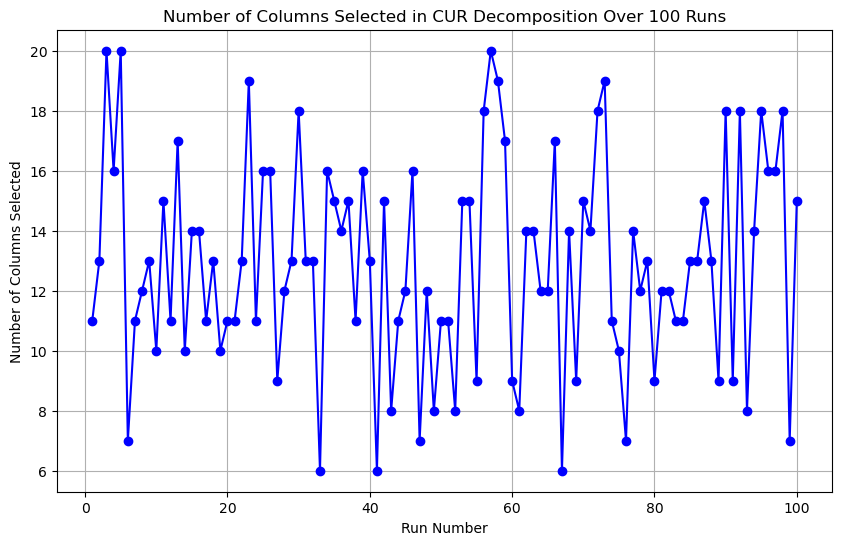

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Function for collecting data on column selections
def collect_column_data(A, k, epsilon, num_runs=100):
    columns_selected = []
    
    for run in range(num_runs):
        _, _, _, col_indices, _ = algorithm_CUR(A, k, epsilon)
        columns_selected.append(len(col_indices))  # Save number of columns selected in each run
    
    return columns_selected

# Sample matrix A (you can replace it with your actual matrix)
A = np.random.rand(250, 250)
k = 3
epsilon = 0.5

# Collect column data for 100 runs
columns_selected_data = collect_column_data(A, k, epsilon, num_runs=100)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), columns_selected_data, marker='o', linestyle='-', color='b')
plt.title("Number of Columns Selected in CUR Decomposition Over 100 Runs")
plt.xlabel("Run Number")
plt.ylabel("Number of Columns Selected")
plt.grid(True)
plt.show()


In [44]:
import pandas as pd

# Full path to your file
file_path = r"D:\CMI\LAA_project\sample_dataset.txt"

# Read the file while skipping metadata lines (start with #)
df = pd.read_csv(file_path, sep="\t", comment="#")

# Drop the first column if it's ID_REF or any identifier
if 'ID_REF' in df.columns:
    df.drop(columns=['ID_REF'], inplace=True)

# Drop all columns that contain any NaN values
df.dropna(axis=1, inplace=True)

# Now extract the cleaned matrix A
Gene_dataset = df.values

Gene_dataset_subset = Gene_dataset[:, :18]



In [46]:
import pandas as pd

df = pd.DataFrame(Gene_dataset_subset)
print(df)


         0        1      2      3        4        5      6      7      8   \
0    1865.0   2279.0  276.0  430.0   1589.0   1849.0  279.0  434.0   98.0   
1    2984.0   3561.0  265.0  416.0   2719.0   3145.0  270.0  418.0   98.0   
2    1912.0   1053.0  268.0  409.0   1644.0    644.0  275.0  414.0   98.0   
3    1139.0   3374.0  268.0  398.0    871.0   2976.0  277.0  411.0   92.0   
4    3856.0    730.0  271.0  393.0   3585.0    337.0  274.0  402.0  100.0   
5    2840.0   2731.0  263.0  396.0   2577.0   2335.0  267.0  405.0  100.0   
6    4043.0   1904.0  254.0  393.0   3789.0   1511.0  260.0  396.0  100.0   
7    1763.0   7307.0  255.0  367.0   1508.0   6940.0  259.0  378.0  100.0   
8    8417.0   3152.0  254.0  365.0   8163.0   2787.0  259.0  375.0   97.0   
9     798.0    577.0  264.0  358.0    534.0    219.0  264.0  373.0   59.0   
10   2061.0   1286.0  261.0  357.0   1800.0    929.0  266.0  361.0   96.0   
11   7003.0   1158.0  260.0  351.0   6743.0    807.0  267.0  356.0  100.0   

In [142]:
k = 2
epsilon = 0.3

C_gene, U_gene, R_gene, selected_columns_genes, selected_rows_genes = algorithm_CUR(Gene_dataset_subset, k, epsilon)

print("Selected Columns Indices:", selected_columns_genes)
print("Selected Rows Indices:", selected_rows_genes)


Selected Columns Indices: [0 1 4 5]
Selected Rows Indices: [ 8 13 16 18 21 24 26]


In [132]:
import pandas as pd

df = pd.DataFrame(C_gene)
print(df)

          0        1        2
0    1865.0   2279.0   1589.0
1    2984.0   3561.0   2719.0
2    1912.0   1053.0   1644.0
3    1139.0   3374.0    871.0
4    3856.0    730.0   3585.0
5    2840.0   2731.0   2577.0
6    4043.0   1904.0   3789.0
7    1763.0   7307.0   1508.0
8    8417.0   3152.0   8163.0
9     798.0    577.0    534.0
10   2061.0   1286.0   1800.0
11   7003.0   1158.0   6743.0
12   4533.0   6647.0   4282.0
13  16137.0   7662.0  15890.0
14   2808.0   2754.0   2558.0
15   6515.0   1615.0   6258.0
16  11638.0   6173.0  11375.0
17    706.0    948.0    444.0
18   7970.0   6376.0   7707.0
19   4064.0   3975.0   3797.0
20   2723.0   2362.0   2450.0
21   5699.0   3910.0   5421.0
22   4519.0   3695.0   4235.0
23   2284.0   1588.0   1999.0
24   7283.0   3426.0   6987.0
25   4850.0   3373.0   4556.0
26   2026.0  27403.0   1738.0
27   1725.0   2399.0   1448.0
28   7789.0   4820.0   7502.0
29   6279.0   4566.0   6011.0


In [70]:
import pandas as pd

df = pd.DataFrame(R_gene)
print(df)

        0        1      2      3        4        5      6      7      8   \
0   1763.0   7307.0  255.0  367.0   1508.0   6940.0  259.0  378.0  100.0   
1   7003.0   1158.0  260.0  351.0   6743.0    807.0  267.0  356.0  100.0   
2  16137.0   7662.0  247.0  321.0  15890.0   7341.0  251.0  325.0   97.0   
3   2808.0   2754.0  250.0  324.0   2558.0   2430.0  258.0  389.0   92.0   
4  11638.0   6173.0  263.0  335.0  11375.0   5838.0  265.0  333.0  100.0   
5   7970.0   6376.0  263.0  340.0   7707.0   6036.0  267.0  347.0   97.0   
6   7283.0   3426.0  296.0  386.0   6987.0   3040.0  300.0  395.0  100.0   
7   2026.0  27403.0  288.0  380.0   1738.0  27023.0  288.0  385.0   82.0   

      9      10      11      12     13     14      15    16    17  
0  100.0  0.217   4.602   5.561   52.0  257.0   3.328  0.80  44.0  
1   86.0  8.356   0.120   0.085   80.0  326.0   0.126  0.83  44.0  
2   96.0  2.165   0.462   0.465  120.0  433.0   0.447  0.95  43.0  
3   59.0  1.053   0.950   0.973   52.0  297

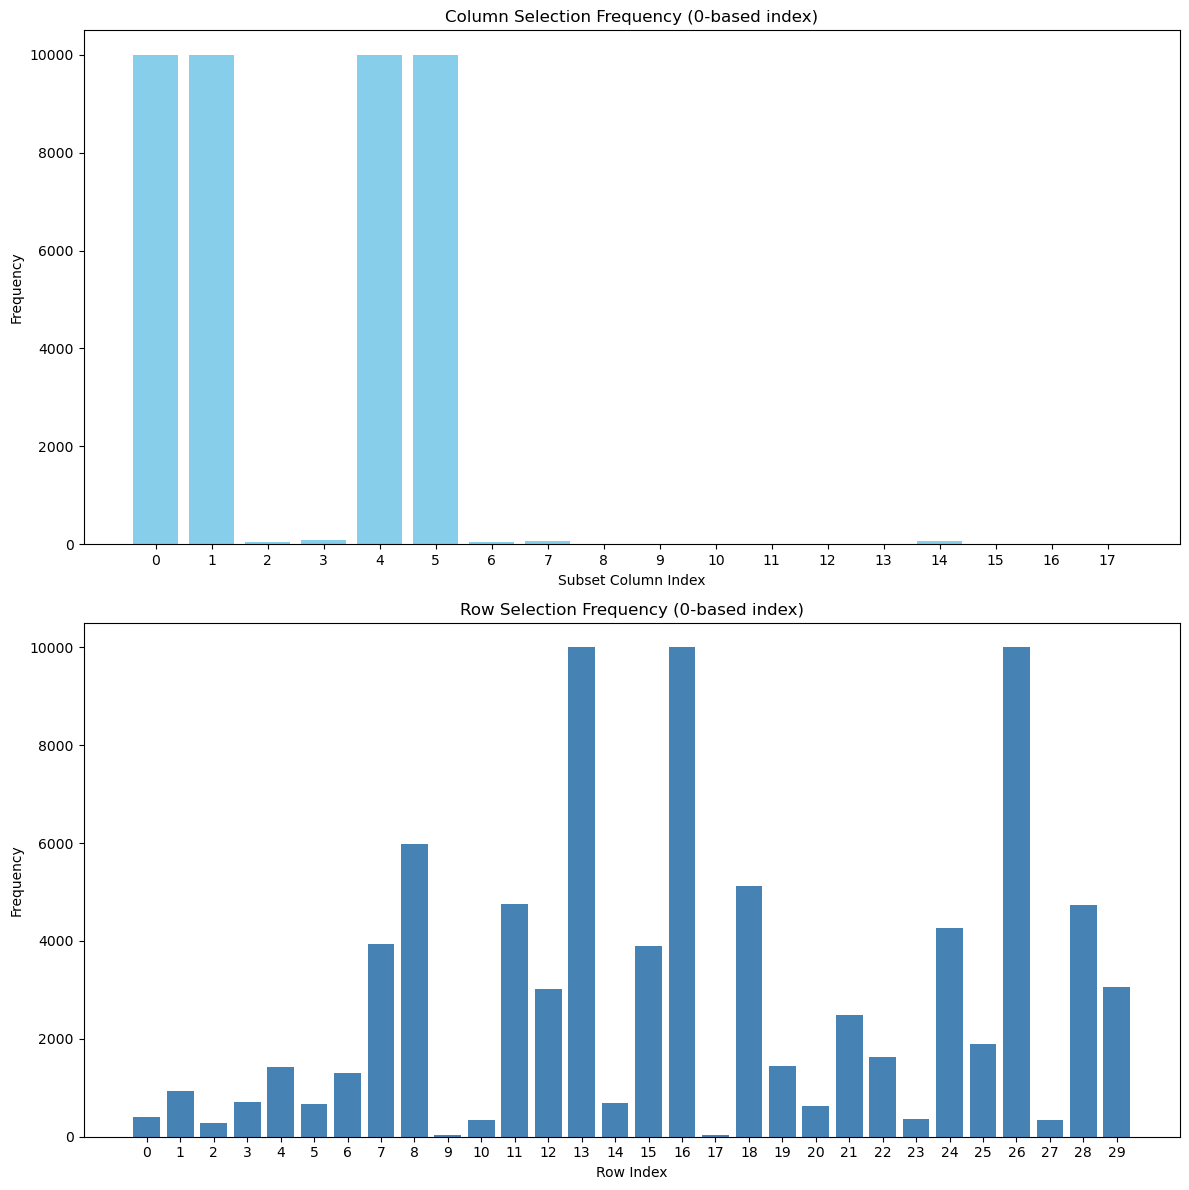

In [166]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize counters for columns and rows
column_counts = np.zeros(Gene_dataset_subset.shape[1])  # Count for each column in subset
row_counts = np.zeros(Gene_dataset_subset.shape[0])     # Count for each row

# Number of iterations
iterations = 10000

# Run CUR for specified iterations and count selected indices
for i in range(iterations):
    C_gene, U_gene, R_gene, selected_columns_genes, selected_rows_genes = algorithm_CUR(Gene_dataset_subset, k, epsilon)
    
    # Update counts
    column_counts[selected_columns_genes] += 1
    row_counts[selected_rows_genes] += 1

# Plot the column and row selection frequencies
plt.figure(figsize=(12, 12))

# Plot for column frequencies
plt.subplot(2, 1, 1)
plt.bar(np.arange(len(column_counts)), column_counts, color='skyblue')
plt.title('Column Selection Frequency (0-based index)')
plt.xlabel('Subset Column Index')
plt.ylabel('Frequency')
plt.xticks(np.arange(len(column_counts)))

# Plot for row frequencies
plt.subplot(2, 1, 2)
plt.bar(np.arange(len(row_counts)), row_counts, color='steelblue')
plt.title('Row Selection Frequency (0-based index)')
plt.xlabel('Row Index')
plt.ylabel('Frequency')
plt.xticks(np.arange(len(row_counts)))

plt.tight_layout()
plt.show()


In [146]:
import pandas as pd
import numpy as np

# Read the file while skipping lines starting with #
df = pd.read_csv("D:\CMI\LAA_project\sample_dataset.txt", sep="\t", comment="#")

# Keep a copy of the original column names
original_columns = df.columns.tolist()

# Drop 'ID_REF' column if it exists
if 'ID_REF' in df.columns:
    df.drop(columns=['ID_REF'], inplace=True)

# Drop columns with any NaNs
df.dropna(axis=1, inplace=True)

# Keep track of cleaned column names (after dropna and drop of ID_REF)
cleaned_column_names = df.columns.tolist()

# Extract the data matrix
Gene_dataset = df.values

# Choose first 18 columns for CUR
Gene_dataset_subset = Gene_dataset[:, :18]

# Keep mapping for those first 18 columns
subset_column_names = cleaned_column_names[:18]


<>:5: SyntaxWarning: invalid escape sequence '\C'
<>:5: SyntaxWarning: invalid escape sequence '\C'
C:\Users\Riya Huddar\AppData\Local\Temp\ipykernel_25400\791556450.py:5: SyntaxWarning: invalid escape sequence '\C'
  df = pd.read_csv("D:\CMI\LAA_project\sample_dataset.txt", sep="\t", comment="#")


In [164]:
def map_subset_index_to_original(subset_index):
    try:
        # Get the name of the column at that index in the subset
        subset_col_name = subset_column_names[subset_index]
        
        # Find its index in the original column list
        original_index = original_columns.index(subset_col_name)
        
        return original_index, subset_col_name
    except IndexError:
        return f"Subset index {subset_index} is out of range (0 to {len(subset_column_names) - 1})"
    except ValueError:
        return f"Column '{subset_col_name}' not found in original columns (this shouldn't happen)"

# Example usage
subset_idx = 5  # Index in your subset (0 to 17)
orig_idx, col_name = map_subset_index_to_original(subset_idx)
print(f"Subset column index {subset_idx} corresponds to original column index {orig_idx} with name '{col_name}'")


Subset column index 5 corresponds to original column index 6 with name 'CH2D_MEAN'
